<a href="https://colab.research.google.com/github/Sergiostef25/IDS-LSTM-PetriNet/blob/main/IDS_LSTM_PetriNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Caricamento Dataset IDS 2018 Intrusion CSV

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras.callbacks import CSVLogger
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
import time
import datetime
from tqdm.auto import tqdm
import random

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
def df_to_X_y(df, window_size=50):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][-1]
    y.append(label)
  return np.array(X), np.array(y)

# Preprocessing

In [ ]:
#!gdown own_kaggle_api_key
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download solarmainframe/ids-intrusion-csv
!unzip ids-intrusion-csv.zip
!rm ids-intrusion-csv.zip

Downloading...
From: https://drive.google.com/uc?id=1Duc3duu_g47yimOcPTRTunPOioCTcXIT
To: /content/kaggle.json
100% 72.0/72.0 [00:00<00:00, 152kB/s]
100% 1.60G/1.60G [00:56<00:00, 36.7MB/s]
100% 1.60G/1.60G [00:56<00:00, 30.5MB/s]
Archive:  ids-intrusion-csv.zip
  inflating: 02-14-2018.csv          
  inflating: 02-15-2018.csv          
  inflating: 02-16-2018.csv          
  inflating: 02-20-2018.csv          
  inflating: 02-21-2018.csv          
  inflating: 02-22-2018.csv          
  inflating: 02-23-2018.csv          
  inflating: 02-28-2018.csv          
  inflating: 03-01-2018.csv          
  inflating: 03-02-2018.csv          


## Data Cleaning

In [ ]:
df = pd.read_csv('02-16-2018.csv')
df = df.loc[df.Timestamp.str.startswith("16")] #inserire il giorno del csv caricato
df.sort_values(by=['Timestamp'],inplace=True,ignore_index=True)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
num_norm = df.loc[df.Label == 'Benign'].shape[0]
num_att = df.loc[df.Label != 'Benign'].shape[0]
print("Pacchetti Normali: ",num_norm)
print("Pacchetti Attacco: ",num_att)

Pacchetti Normali:  446772
Pacchetti Attacco:  601802


In [ ]:
df_benign = df.loc[df.Label == 'Benign']
df_attack = df.loc[df.Label != 'Benign']

att_norm = df_attack.shape[0]/df_benign.shape[0]

if att_norm > 1:
  df_attack = df_attack.iloc[:df_benign.shape[0]]
else:
    df_benign = df_benign.iloc[:df_attack.shape[0]]

print("Vecchio Attacco/Normali = "+str(att_norm))
print("Nuovo Attacco/Normali = "+str(df_attack.shape[0]/df_benign.shape[0]))
df = df_benign.append(df_attack, ignore_index=True)

Vecchio Attacco/Normali = 1.347000259640264
Nuovo Attacco/Normali = 1.0


In [ ]:
df.shape

(893544, 80)

In [ ]:
df.sort_values(by=['Timestamp'],inplace=True,ignore_index=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893544 entries, 0 to 893543
Data columns (total 80 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Dst Port           893544 non-null  object
 1   Protocol           893544 non-null  object
 2   Timestamp          893544 non-null  object
 3   Flow Duration      893544 non-null  object
 4   Tot Fwd Pkts       893544 non-null  object
 5   Tot Bwd Pkts       893544 non-null  object
 6   TotLen Fwd Pkts    893544 non-null  object
 7   TotLen Bwd Pkts    893544 non-null  object
 8   Fwd Pkt Len Max    893544 non-null  object
 9   Fwd Pkt Len Min    893544 non-null  object
 10  Fwd Pkt Len Mean   893544 non-null  object
 11  Fwd Pkt Len Std    893544 non-null  object
 12  Bwd Pkt Len Max    893544 non-null  object
 13  Bwd Pkt Len Min    893544 non-null  object
 14  Bwd Pkt Len Mean   893544 non-null  object
 15  Bwd Pkt Len Std    893544 non-null  object
 16  Flow Byts/s        8

In [ ]:
df.dtypes

Dst Port         object
Protocol         object
Timestamp        object
Flow Duration    object
Tot Fwd Pkts     object
                  ...  
Idle Mean        object
Idle Std         object
Idle Max         object
Idle Min         object
Label            object
Length: 80, dtype: object

In [ ]:
df.Label.unique()

array(['Benign', 'DoS attacks-Hulk'], dtype=object)

In [ ]:
df.Label = df.Label.map(lambda a: 0 if a == 'Benign' else 1)
df.Label = pd.to_numeric(df.Label)
df.Label.unique()

array([0, 1])

In [ ]:
df.isnull()

In [ ]:
pd.Categorical(df['Flow Byts/s'])

In [ ]:
pd.Categorical(df['Flow Pkts/s'])


In [ ]:
df.drop(['Bwd PSH Flags','Fwd URG Flags','Bwd URG Flags','CWE Flag Count','Fwd Byts/b Avg','Fwd Pkts/b Avg','Fwd Blk Rate Avg','Bwd Byts/b Avg','Bwd Pkts/b Avg','Bwd Blk Rate Avg'],axis=1,inplace=True)


In [ ]:
df.isnull().sum()

In [ ]:
df['Flow Pkts/s']= df['Flow Pkts/s'].fillna(0)  # removing NAN and INF values
df['Flow Byts/s']= df['Flow Byts/s'].fillna(0)
df['Flow Pkts/s']= df['Flow Pkts/s'].replace(np.Infinity,1)
df['Flow Byts/s']= df['Flow Byts/s'].replace(np.Infinity,1)
df['Flow Pkts/s']= df['Flow Pkts/s'].replace('Infinity',1)
df['Flow Byts/s']= df['Flow Byts/s'].replace('Infinity',1)

In [ ]:
pd.Categorical(df['Flow Byts/s'])

In [ ]:
 pd.Categorical(df['Flow Pkts/s'])

In [ ]:
df.drop('Timestamp', axis=1, inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df[['Label']], test_size=0.15, shuffle=False)

In [ ]:
X_train.head()

In [ ]:
sc = StandardScaler()
for column in X_train:
  X_train[column] = sc.fit_transform(X_train[column].values.reshape(-1,1))
for column in X_test:
  X_test[column] = sc.transform(X_test[column].values.reshape(-1,1))

## Correlation Matrix

In [ ]:
correlated_features = set()
correlation_matrix = X_train.corr()

In [ ]:
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [ ]:
len(correlated_features)

In [ ]:
print(correlated_features)

In [ ]:
X_train.drop(labels=correlated_features, axis=1, inplace=True)
X_test.drop(labels=correlated_features, axis=1, inplace=True)

In [ ]:
X_train.head()

In [ ]:
print(X_train.shape)
print(X_test.shape)

## Principal Component Analysis

In [ ]:
pca = PCA()
principalComponents = pca.fit_transform(X_train)

In [ ]:
# Calculate the variance explained by priciple components
print('Variance of each component:', pca.explained_variance_ratio_)
print('\n Total Variance Explained:', round(sum(list(pca.explained_variance_ratio_))*100, 2))

Variance of each component: [1.48324372e-01 1.23027377e-01 1.17367553e-01 1.08688257e-01
 8.69839642e-02 7.63911409e-02 6.06338662e-02 5.17829888e-02
 4.46553062e-02 3.78001121e-02 3.74885160e-02 3.43221294e-02
 2.49405757e-02 1.76886119e-02 1.55182988e-02 1.43869311e-02
 4.53102852e-35 2.35959783e-37]

 Total Variance Explained: 100.0


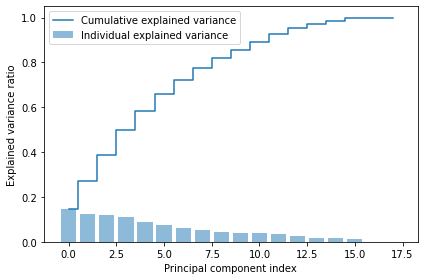

In [ ]:
# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
pca_def = PCA(n_components=13)
principalComponents_train = pca_def.fit_transform(X_train)
df_pca_train = pd.DataFrame(data = principalComponents_train)
df_pca_train['Label'] = y_train

In [ ]:
df_pca_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,Label
0,5.074604,0.162982,-37.948500,-83.421649,-116.180270,-22.494404,6.406088,6.521164,79.378003,-1.263564,104.454578,21.091575,0.653150,0
1,0.173635,4.461345,1.053695,0.692999,-0.736592,-1.279925,-0.020321,-0.516545,0.632227,0.455594,-0.646437,-0.109694,-3.806546,0
2,5.071693,0.163206,-37.948894,-83.421672,-116.180261,-22.494358,6.406177,6.523266,79.378146,-1.263568,104.453856,21.093984,0.652938,0
3,2.598003,120.839396,69.087613,171.341563,830.636674,123.686500,7.649916,14.324288,217.569203,-12.495999,292.079718,60.465977,-22.163114,0
4,5.073123,0.163096,-37.948694,-83.421662,-116.180265,-22.494383,6.406132,6.522233,79.378071,-1.263565,104.454214,21.092801,0.653048,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
759507,-0.105447,-0.019767,0.963910,-0.242008,-0.114368,0.408671,-0.341667,0.038493,0.087475,0.337786,-0.001591,0.008383,-0.078040,1
759508,-0.105009,-0.020077,0.960488,-0.241214,-0.114432,0.409119,-0.344189,0.038837,0.090110,0.337454,-0.003026,0.007585,-0.080469,1
759509,-0.105378,-0.019801,0.963597,-0.241953,-0.114505,0.409508,-0.339269,0.038477,0.087925,0.337379,-0.001902,0.008203,-0.078548,1
759510,-0.105037,-0.020057,0.960714,-0.241267,-0.114431,0.409112,-0.343951,0.038813,0.089942,0.337466,-0.002936,0.007635,-0.080317,1


In [ ]:
principalComponents_test = pca_def.transform(X_test)
df_pca_test = pd.DataFrame(data = principalComponents_test)
df_pca_test['Label'] = y_test.values

In [ ]:
df_pca = pd.concat([df_pca_train, df_pca_test])
#df_pca.to_csv('/content/drive/MyDrive/Colab Notebooks/df_pca.csv',sep=';', index=False)
df_pca

,0,1,2,3,4,5,6,7,8,9,10,11,12,Label
0,5.074604,0.162982,-37.948500,-83.421649,-116.180270,-22.494404,6.406088,6.521164,79.378003,-1.263564,104.454578,21.091575,0.653150,0
1,0.173635,4.461345,1.053695,0.692999,-0.736592,-1.279925,-0.020321,-0.516545,0.632227,0.455594,-0.646437,-0.109694,-3.806546,0
2,5.071693,0.163206,-37.948894,-83.421672,-116.180261,-22.494358,6.406177,6.523266,79.378146,-1.263568,104.453856,21.093984,0.652938,0
3,2.598003,120.839396,69.087613,171.341563,830.636674,123.686500,7.649916,14.324288,217.569203,-12.495999,292.079718,60.465977,-22.163114,0
4,5.073123,0.163096,-37.948694,-83.421662,-116.180265,-22.494383,6.406132,6.522233,79.378071,-1.263565,104.454214,21.092801,0.653048,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134027,0.896607,-1.045407,-8.835351,1.864651,-0.766934,3.502719,0.750855,0.753292,7.644504,-1.982376,-4.255222,-2.414346,-7.264405,0
134028,0.896603,-1.045407,-8.835356,1.864652,-0.766934,3.502721,0.750856,0.753295,7.644508,-1.982377,-4.255226,-2.414344,-7.264409,0
134029,0.896603,-1.045407,-8.835354,1.864652,-0.766934,3.502720,0.750855,0.753295,7.644506,-1.982377,-4.255224,-2.414343,-7.264407,0
134030,-0.163759,-0.288497,-0.587919,0.001121,-0.266168,0.323392,-0.128520,0.015047,0.759563,-0.181597,-0.355091,-0.092988,-0.639684,0


In [ ]:
# Calculate the variance explained by priciple components
print('Variance of each component:', pca_def.explained_variance_ratio_)
print('\n Total Variance Explained:', round(sum(list(pca_def.explained_variance_ratio_))*100, 2))

Variance of each component: [0.14832437 0.12302738 0.11736755 0.10868826 0.08698396 0.07639114
 0.06063387 0.05178299 0.04465531 0.03780011 0.03748852 0.03432213
 0.02494058]

 Total Variance Explained: 95.24


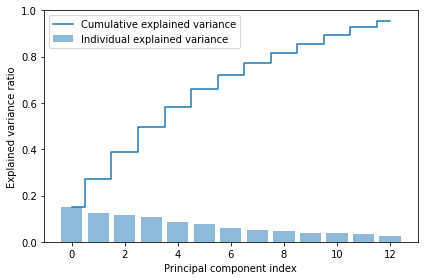

In [ ]:
# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = pca_def.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Training del modello LSTM per l'Intrusion Detection System di pacchetti di retee

## LSTM

In [ ]:
X, y = df_to_X_y(df_pca)
X.shape, y.shape

((893494, 50, 14), (893494,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, shuffle=False)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((645548, 50, 14),
 (645548,),
 (113921, 50, 14),
 (113921,),
 (134025, 50, 14),
 (134025,))

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
print("Distribuzione label in y_train")
print(unique)
print(counts)
if counts.shape[0] > 1: #controlla che ci siano entrambe le label
  print("0/1 Ratio: "+str(counts[0]/counts[1]))
unique, counts = np.unique(y_val, return_counts=True)
print("Distribuzione label in y_val")
print(unique)
print(counts)
if counts.shape[0] > 1:
  print("0/1 Ratio: "+str(counts[0]/counts[1]))
unique, counts = np.unique(y_test, return_counts=True)
print("Distribuzione label in y_test")
print(unique)
print(counts)
if counts.shape[0] > 1:
  print("0/1 Ratio: "+str(counts[0]/counts[1]))

Distribuzione label in y_train
[0. 1.]
[319685 325863]
0/1 Ratio: 0.9810411123693086
Distribuzione label in y_val
[0. 1.]
[55229 58692]
0/1 Ratio: 0.9409970694472841
Distribuzione label in y_test
[0. 1.]
[71816 62209]
0/1 Ratio: 1.1544310308797763


In [ ]:
model = Sequential()
model.add(LSTM(80,input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True)) 
model.add(Dropout(0.3))
model.add(LSTM(80,return_sequences=True))  
model.add(Dropout(0.3))
model.add(LSTM(80, return_sequences=True)) 
model.add(Dropout(0.3))
model.add(LSTM(80, return_sequences=True))  
model.add(Dropout(0.3))
model.add(LSTM(80, return_sequences=True))  
model.add(Dropout(0.3))
model.add(LSTM(80, return_sequences=False))  
model.add(Dropout(0.3))
model.add(Dense(1))# the no. of output classes
model.add(Activation('sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy', optimizer=Adam(),metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 80)            30400     
                                                                 
 dropout (Dropout)           (None, 50, 80)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 80)            51520     
                                                                 
 dropout_1 (Dropout)         (None, 50, 80)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50, 80)            51520     
                                                                 
 dropout_2 (Dropout)         (None, 50, 80)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50, 80)            5

In [ ]:
csv_logger = CSVLogger('/content/drive/MyDrive/Colab Notebooks/lstm_IDS_model_new.csv',separator=';', append=False)

In [ ]:
history = model.fit(X_train, y_train, batch_size=512, epochs=5, validation_data=(X_val, y_val), callbacks=[csv_logger], verbose=1)
model.save('/content/drive/MyDrive/Colab Notebooks/lstm_IDS_model_new.h5')

Epoch 1/5
1261/1261 [==============================] - 64s 41ms/step - loss: 0.0256 - accuracy: 0.9948 - val_loss: 0.0171 - val_accuracy: 0.9966
Epoch 2/5
1261/1261 [==============================] - 51s 40ms/step - loss: 0.0161 - accuracy: 0.9969 - val_loss: 0.0173 - val_accuracy: 0.9967
Epoch 3/5
1261/1261 [==============================] - 52s 41ms/step - loss: 0.0159 - accuracy: 0.9970 - val_loss: 0.0168 - val_accuracy: 0.9968
Epoch 4/5
1261/1261 [==============================] - 52s 41ms/step - loss: 0.0158 - accuracy: 0.9969 - val_loss: 0.0169 - val_accuracy: 0.9968
Epoch 5/5
1261/1261 [==============================] - 52s 41ms/step - loss: 0.0158 - accuracy: 0.9970 - val_loss: 0.0167 - val_accuracy: 0.9968


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print("\nLoss: %.2f, Accuracy: %.2f%%" % (loss, accuracy*100))
predict_x=model.predict(X_test)
classes_x=np.where(predict_x > 0.5, 1,0)

4189/4189 [==============================] - 37s 9ms/step - loss: 0.0149 - accuracy: 0.9971

Loss: 0.01, Accuracy: 99.71%
4189/4189 [==============================] - 35s 8ms/step


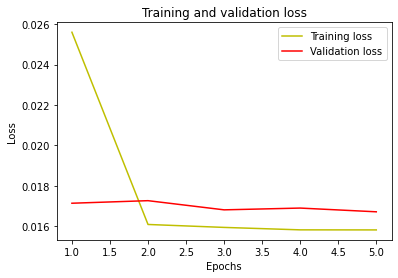

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

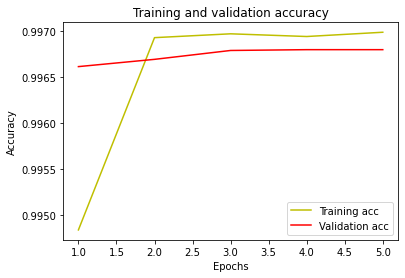

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
expected = y_test
predicted = classes_x
cm = confusion_matrix(expected, predicted)
tn, fp, fn, tp = cm.ravel()
print("TN: ",tn)
print("FP: ",fp)
print("FN: ",fn)
print("TP: ",tp)
print(classification_report(expected,predicted,zero_division=1))

TN:  71620
FP:  196
FN:  196
TP:  62013
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     71816
         1.0       1.00      1.00      1.00     62209

    accuracy                           1.00    134025
   macro avg       1.00      1.00      1.00    134025
weighted avg       1.00      1.00      1.00    134025



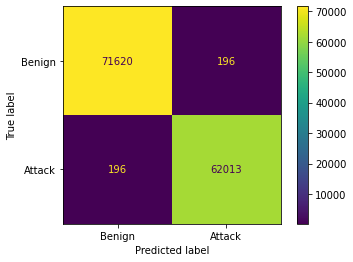

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign','Attack'])
disp.plot()
plt.show()

# Rete di Petri

## Funzioni e classi

In [ ]:
#!gdown gdrive_link_model
#model = keras.models.load_model('lstm_IDS_model_new.h5')

Downloading...
From: https://drive.google.com/uc?id=1pSjEpu_L128tJJ0bh2wkvkYwbPGdEZpB
To: /content/lstm_IDS_model_new.h5
100% 3.56M/3.56M [00:00<00:00, 148MB/s]


In [ ]:
df_test = df_pca.iloc[round(len(df_pca)*0.85):,:]

Downloading...
From: https://drive.google.com/uc?id=1JtjX_ZpTBIjZ2qSuejtMM73KY0n_mW5a&confirm=t
To: /content/df_pca.csv
100% 238M/238M [00:01<00:00, 130MB/s]


In [ ]:
def predict_attack(var):
  X_sample, y_sample = df_to_X_y(var[0].iloc[var[1]:var[1]+51])
  predict_x = model.predict(X_sample)
  predicted = np.where(predict_x > 0.5, 1, 0)[0][0] #1 attack, 0 normal
  return predicted

def predict_benign(var):
  X_sample, y_sample = df_to_X_y(var[0].iloc[var[1]:var[1]+51])
  predict_x = model.predict(X_sample)
  predicted = np.where(predict_x > 0.5, 0, 1)[0][0] #1 normal, 0 attack
  return predicted

In [ ]:
def start_net():
  df_bloc = pd.DataFrame(columns=net.global_var[0].columns)
  df_not_bloc =pd.DataFrame(columns=net.global_var[0].columns)
  net.global_var.append(df_bloc) #pacchetti bloccati
  net.global_var.append(df_not_bloc) #pacchetti non bloccati
  for i in range(10):
    net.fire(t1)
    #print('Pacchetto 1 arrivato')
    for i in tqdm(range(1, 51)):
      time.sleep(0.1)
      #print('Pacchetto',i+1,'arrivato')
      net.fire(t1)
    #net.marking
    net.fire(t2)
    if net.marking['p2'] == 0 and net.marking['p3'] == 1:
      print('Benign packet flow')
      net.fire(t4)
      net.global_var[3] = pd.concat([net.global_var[3],net.global_var[0].iloc[net.global_var[1]:net.global_var[1]+51]], ignore_index=True)
    else:
      print('Attack packet flow')
      net.fire(t3)
      net.global_var[2] = pd.concat([net.global_var[2],net.global_var[0].iloc[net.global_var[1]:net.global_var[1]+51]], ignore_index=True)
    
    net.global_var[1] += 51

      
  print('')
  print('Blocked packets: ',net.marking['a'])
  print('Unblocked packets: ',net.marking['n'])
  print('')
  mal = len(net.global_var[2].loc[net.global_var[2]['Label'] == 1])
  ben = len(net.global_var[2].loc[net.global_var[2]['Label'] == 0])
  
  if mal+ben != 0:
    perc = round(mal*100/(ben+mal),2)
    print('Percetage of blocked attack packets:',perc,'%')
    print('Percetage of blocked benign packets:',round(100-perc,2),'%')
  else:
    print('Percetage of blocked attack packets: 0 %')
  
  print('')
  mal = len(net.global_var[3].loc[net.global_var[3]['Label'] == 1])
  ben = len(net.global_var[3].loc[net.global_var[3]['Label'] == 0])

  if mal+ben != 0:
    perc = round(mal*100/(ben+mal),2)
    print('Percetage of unblocked attack packets:',perc,'%')
    print('Percetage of unblocked benign packets:',round(100-perc,2),'%')
  else:
    print('Percetage of unblocked attack packets: 0 %')
  
  

In [ ]:
class Place:
  def __init__(self, name, token=0):
    self.name = name
    self.token = token

class Transition:
  def __init__(self, name):
    self.name = name
    self.input_arc = {}
    self.output_arc = {}

class Net:
  def __init__(self, name, global_var = None):
    self.name = name
    self.marking = {}
    self.transitions = {}
    self.global_var = global_var

  def add_place(self, pl):
    self.marking.update({pl.name : pl.token})

  def add_transition(self, trans):
    self.transitions.update({trans.name : {'input' : trans.input_arc,'output' : trans.output_arc}})

  def add_input(self, trans, pl, weight = 1):
    try:
      self.transitions[trans.name]
      self.marking[pl.name]
    except:
      print('Transizione e/o posti non inseriti nella rete, impossibile inserire l\'arco')
    else:
      trans.input_arc.update({pl.name:weight})
      self.transitions.update({trans.name : {'input' : trans.input_arc,'output' : trans.output_arc}})

  def add_output(self, trans, pl, weight = 1):
    try:
      self.transitions[trans.name]
      self.marking[pl.name]
    except:
      print('Transizione e/o posti non inseriti nella rete, impossibile inserire l\'arco')
    else:
      trans.output_arc.update({pl.name:weight})
      self.transitions.update({trans.name : {'input' : trans.input_arc,'output' : trans.output_arc}})

  def fire(self, trans):
    enable = True
    try:
      self.transitions[trans.name]
    except:
      print('Transizione e/o posti non inseriti nella rete, impossibile inserire l\'arco')
    else:
      check = 0
      for p, t in trans.input_arc.items():
        if self.marking[p] >= t:
          check += 1
      if check == len(trans.input_arc) :
        for p, t in trans.input_arc.items():
          self.marking[p] -= t
        for p, t in trans.output_arc.items():
          if isinstance(t, str):
            self.marking[p] = eval(t)
          else:
            self.marking[p] += t
      else:
        print(trans.name + ' non può essere abilitata')
        enable = False
      return enable

  def print_pre_matrix(self):
    for t, i in self.transitions.items():
      print(t,i['input'])

  def print_post_matrix(self):
    for t, i in self.transitions.items():
      print(t,i['output'])
     

## Petri Net and execution

In [ ]:
start = random.randint(0, len(df_test)-510)
net = Net('net', [df_test, start])
#posti
p1 = Place('p1')
b = Place('b',51)
p2 = Place('p2')
p3 = Place('p3')
a = Place('a')
n = Place('n')
net.add_place(p1)
net.add_place(p2)
net.add_place(p3)
net.add_place(b)
net.add_place(a)
net.add_place(n)
#transizioni
t1 = Transition('t1')
t2 = Transition('t2')
t3 = Transition('t3')
t4 = Transition('t4')
net.add_transition(t1)
net.add_transition(t2)
net.add_transition(t3)
net.add_transition(t4)
#archi
#t1
net.add_input(t1,b)
net.add_output(t1,p1)
#t2
net.add_input(t2,p1,51)
net.add_output(t2,p2,'predict_attack(net.global_var)')
net.add_output(t2,p3,'predict_benign(net.global_var)')
#t3
net.add_input(t3,p2)
net.add_output(t3,a,51)
net.add_output(t3,b,51)
#t4
net.add_input(t4,p3)
net.add_output(t4,n,51)
net.add_output(t4,b,51)

In [ ]:
start_net()

  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step
Benign packet flow


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step
Benign packet flow


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step
Benign packet flow


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step
Benign packet flow


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step
Benign packet flow


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step
Benign packet flow


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step
Benign packet flow


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step
Benign packet flow


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step
Benign packet flow


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step
Benign packet flow

Blocked packets:  0
Unblocked packets:  510

Percetage of blocked attack packets: 0 %

Percetage of unblocked attack packets: 0.2 %
Percetage of unblocked benign packets: 99.8 %
